In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline
from IPython.display import Image

# Bayes Statistik IV

# MCMC Implementierung in Python: PyStan

- PyStan: Stan-Implementierung in Python
- Einführungs-Beispiel: Münzwurf
    - Modell
        - Prior
        - Daten und Likelihood
    - Aufruf
    - Ergebnis
        - Markov-Kette
        - Graphik
        - Schätzer
- Optionen
    - Wiederverwendung
    - Burn in
- Erweitertes Beispiel: Zweidimensional
    - Verbundwahrscheinlichkeit Posterior
    - Auswertung
- Zusammenfassung

## Ziel
- Stichproben aus dem Posterior gewinnen
- Daraus Statistik
    - Punktschätzer
    - Intervallschätzer 

## Vorgehen
- Markov Chain Monte Carlo Methode *MCMC*: Hamiltonian Monte Carlo
    - *no U-Turn sampler* (NUTS)
- effektive Stichproben aus Posterior-Verteilung
    - umgeht Problem Ineffektivität (Korrelation, Schwänze der Verteilung, Mehrfachberechnung)
    - adaptiert an Verteilung (unterschiedliche Form)

# Implementierung: Stan

![Logo_stan_homepage_klein.png](images/Logo_stan_homepage_klein.png)

> Stan, named after Stanislaw Ulam, a mathematician who was one of the developers of the
> Monte Carlo method in the 1940s (Metropolis & Ulam, 1949), is a C++ program to perform
> Bayesian inference. The code is open-source and is available at http://mc-stan.org/ 
> along with instructions and a 500-page user manual. 
> Stan 1.0 was released in 2012

Zitat aus: http://www.stat.columbia.edu/~gelman/research/published/stan_jebs_2.pdf der Stan-Autoren

"Sampling Through Adaptive Neighborhoods"

- NUTS (*No-U-Turn Sampler*; Variante von Hamiltonian MC)
- Für Python, C++, R, Shell, Julia, Matlab, ....
- open-source software (new BSD; PyStan GPL V3)
- Version 2.17.1 (Dez. 2017)
- Link: http://mc-stan.org/
- Literatur: http://mc-stan.org/users/documentation/index.html

# PyStan

**Lizenz**: GPL v.3

#### Webseiten
- https://pystan.readthedocs.io/en/latest/
- http://mc-stan.org/users/interfaces/pystan.html
- https://pypi.python.org/pypi/pystan

#### Installation
- ``conda install pystan``
    - aktuell mit conda: ``pystan   2.17.1.0   py36h637b7d7_0``
- ``pip install pystan``

#### Voraussetzungen
- Compiler (Betriebssystem): ``gcc, gcc-c++``
- C für Python (conda, aktuell): ``cython-0.28.3`` 

#### Verwendung

In [3]:
import pystan       # Stan for Python

# Einführendes Beispiel in PyStan: Münzwurf

## Modell
- Prior Verteilung: $\;p(\theta)$
    - Beta-Verteilung
$$\theta \sim \text{Beta}(a, b)$$
    - mit normalisierender Beta-Funktion
$$p(\theta\,|\,a,b) = \theta^{a-1}(1-\theta)^{b-1}\;/\;\mathrm{B}(a,b)$$
- Daten: $\; z$ aus $N$
- Likelihood-Funktion: $p(D|\theta)$
    - Bernoulli
$$y_i \sim \text{Bernoulli}(\theta)$$

$$p(\mathbf{y}\,|\,\theta) = \theta^{\, z}(1-\theta)^{N-z}$$


## PyStan Modellbeschreibung

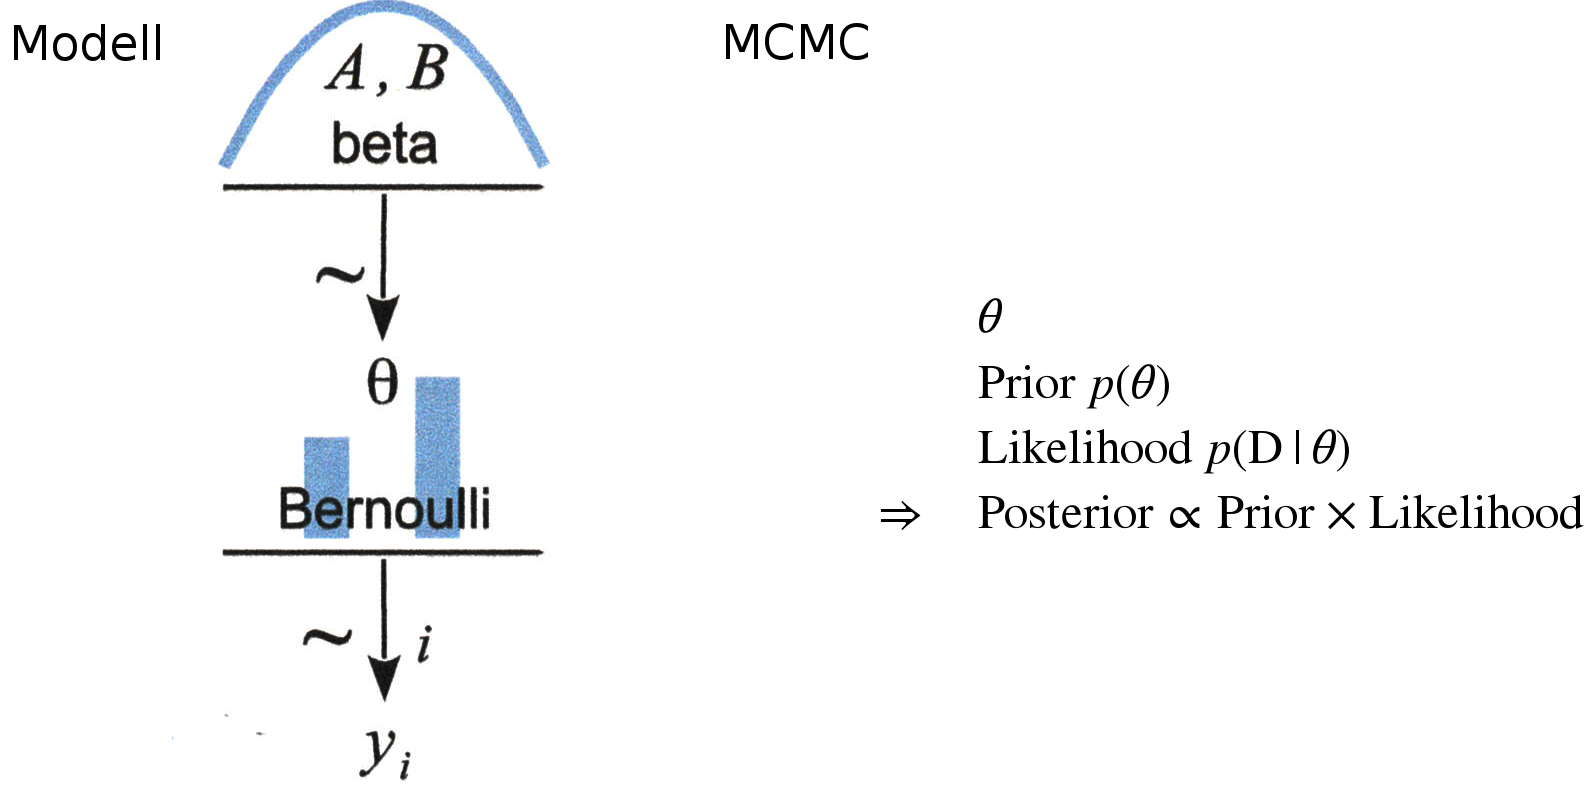

In [3]:
'''model description in (Py)Stan - and how to process
   after: Kruschke: Doing Bayesian Data Analysis, 2nd. AP (2015)'''

In [4]:
'''the model as a string; will be interpreted by (Py)Stan'''

mycoinmodel = """
data {
    int<lower=0> Ntotal;  // number of tosses
    int y[Ntotal];        // data 0=tails, 1=heads; has to be supplied
}
parameters {
    real<lower=0, upper=1> theta; // the (restricted) parameter, we are interested in
}
model {
    theta ~ beta( 0.5, 0.5 ); // prior for parameter; a more tricky one
    y ~ bernoulli( theta );  // vectorized likelihood for data, built-in bernoulli
}             
"""

### Verteilungen

    bernoulli
    bernoulli_logit
    beta
    beta_binomial
    binomial
    binomial_logit
    cauchy
    chi_square
    exponential
    gamma
    logistic
    multinomial
    multi_normal
    normal
    pareto
    student_t
    uniform
    ...

## Prior

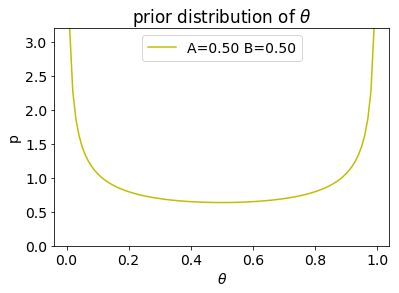

In [5]:
'''show prior distribution of theta with assumed parameters A and B'''
A = 0.5                # parameters of Beta-distribution
B = 0.5                #   we assume trick coins
thetas = np.linspace(0., 1., 100+1)# dense grid for parameter of interest:theta 
ptheta = stats.beta(A, B).pdf(thetas)# Prior probability density
plt.plot(thetas, ptheta, 'y-', label='A={:.2f} B={:.2f}'.format(A, B))
plt.title('prior distribution of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('p')
plt.ylim((0., 3.2))
plt.legend(loc='upper center');

## Daten und Likelihood

In [7]:
'''get data: example from Kruschke book'''
import pandas as pd

data = pd.read_csv('KruschkePrograms/z15N50.csv', sep='\\t', engine='python')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 1 columns):
"y"    50 non-null int64
dtypes: int64(1)
memory usage: 480.0 bytes


In [8]:
print( '1st 5 values of y : \n{}'.format(data['"y"'].head(5)) )
print( 'the mean of {} values is {:.5f}'.format(
                    len(data['"y"']), np.asarray(data.mean())[0]) )
# double quotes belong to name; mean() gives (mean, N) so use 1st number only

1st 5 values of y : 
0    0
1    1
2    0
3    0
4    0
Name: "y", dtype: int64
the mean of 50 values is 0.30000


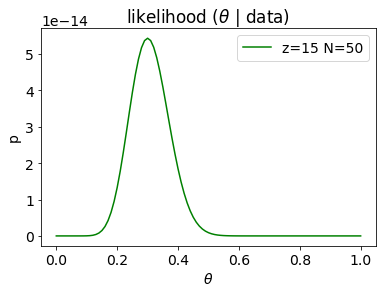

In [9]:
'''show likelihood of data (z=15, N=50) under theta'''
def likelihood(t, z, N):
    # Bernoulli Likelihood for data with z 1s under N trials
    return t**z * (1-t)**(N-z)

z = 15                                 # heads among
n = 50                                 # tosses
thetas = np.linspace(0., 1., 100+1)    # dense grid
plt.plot(thetas, likelihood(thetas, z, n), 'g-',
         label='z={} N={}'.format(z, n))
plt.title('likelihood ($\\theta$ | data)')
plt.xlabel('$\\theta$')
plt.ylabel('p')
plt.legend(loc='upper right');

### Daten in PyStan

In [10]:
'''data in a dictionary, needed by PyStan; names according to model-string'''
mydata = { 
    'Ntotal': len(data['"y"']),
    'y'     : np.asarray(data['"y"'])
}

print(mydata, type(mydata))

{'Ntotal': 50, 'y': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0])} <class 'dict'>


## PyStan Aufruf

In [11]:
'''NOT NEEDED ANYMORE'''
'''.../envs/statistik/lib/python3.5/multiprocessing/reduction.py:50: 
   UserWarning: Pickling fit objects is an experimental feature!
   The relevant StanModel instance must be pickled along with this fit object.
   When unpickling the StanModel must be unpickled first.
     cls(buf, protocol).dump(obj)
'''

# ignore those pickle warnings always in the fit by applying a decorator 
import warnings

def decorator(function):
    def wrapper(*args, **kwargs):
        warnings.simplefilter("ignore")
        return function(*args, **kwargs)
    return wrapper

pystan.stan = decorator(pystan.stan) # from now on without warnings:

In [11]:
fit1 = pystan.stan(model_code=mycoinmodel, data=mydata, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2455a0683131c4d2f1d0a2322c6d1670 NOW.


### Berechnung:
        Iteration:   1 / 1000 [  0%]  (Warmup)
        Iteration:   1 / 1000 [  0%]  (Warmup)
        Iteration:   1 / 1000 [  0%]  (Warmup)
        Iteration:   1 / 1000 [  0%]  (Warmup)
        Iteration: 100 / 1000 [ 10%]  (Warmup)
    [...]
        Iteration: 500 / 1000 [ 50%]  (Warmup)
        Iteration: 500 / 1000 [ 50%]  (Warmup)
        Iteration: 501 / 1000 [ 50%]  (Sampling)
        Iteration: 501 / 1000 [ 50%]  (Sampling)
    [...]
        Iteration: 900 / 1000 [ 90%]  (Sampling)
        Iteration: 1000 / 1000 [100%]  (Sampling)
        Elapsed Time: 0.01 seconds (Warm-up)
                      0.01 seconds (Sampling)
                      0.02 seconds (Total)
        Iteration: 1000 / 1000 [100%]  (Sampling)
        Elapsed Time: 0.01 seconds (Warm-up)
                      0.01 seconds (Sampling)
                      0.02 seconds (Total)
        Iteration: 1000 / 1000 [100%]  (Sampling)
        Iteration: 1000 / 1000 [100%]  (Sampling)
        Elapsed Time: 0 seconds (Warm-up)
                      0.01 seconds (Sampling)
                      0.01 seconds (Total)
        Elapsed Time: 0 seconds (Warm-up)
                      0.01 seconds (Sampling)
                      0.01 seconds (Total)

## Auswertung

In [12]:
'''result statistics'''
print(fit1)

Inference for Stan model: anon_model_2455a0683131c4d2f1d0a2322c6d1670.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    0.3  2.4e-3   0.06   0.19   0.26    0.3   0.35   0.44    690    1.0
lp__  -31.84    0.02   0.72 -33.93 -32.01 -31.55 -31.38 -31.32    834    1.0

Samples were drawn using NUTS at Tue Jun 19 13:19:10 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


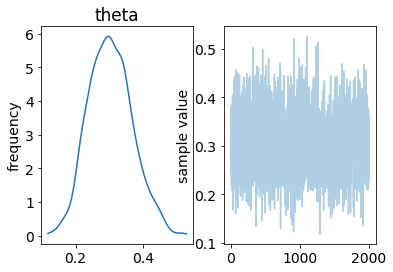

In [13]:
'''show result graphically with built in plot()'''
myplot = fit1.plot()

In [14]:
'''complete result: the chains'''
myresult = fit1.extract(permuted=False)
print(myresult)

[[[  0.4650452  -34.07496265]
  [  0.35571448 -31.62748889]
  [  0.40772194 -32.50028926]
  [  0.41424271 -32.64736633]]

 [[  0.22523749 -32.16385396]
  [  0.36895526 -31.79817559]
  [  0.3665392  -31.76435118]
  [  0.4130774  -32.62047706]]

 [[  0.25195689 -31.67216849]
  [  0.25679266 -31.60773516]
  [  0.42323339 -32.86366247]
  [  0.34884992 -31.55329588]]

 ...

 [[  0.3493818  -31.55869088]
  [  0.30777817 -31.32346053]
  [  0.34271367 -31.4953911 ]
  [  0.28467301 -31.36746911]]

 [[  0.36667368 -31.76620266]
  [  0.22001255 -32.28904501]
  [  0.36257034 -31.71137283]
  [  0.27565169 -31.42170999]]

 [[  0.41879148 -32.75484514]
  [  0.4056619  -32.45554188]
  [  0.32033563 -31.35352708]
  [  0.25233916 -31.66681573]]]


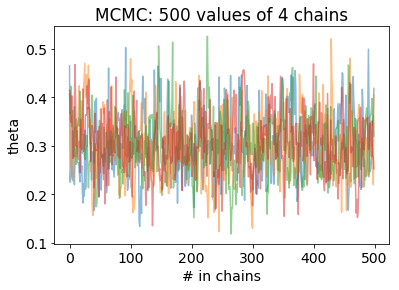

In [15]:
'''the four Monte Carlo chains'''
plt.plot(myresult[:, :, 0], alpha =.5)    # plot all 4 chains
plt.title('MCMC: {} values of {} chains'.format(
                    myresult.shape[0], myresult.shape[1]))
plt.xlabel('# in chains')
plt.ylabel('theta');

(500, 4)
(2000,)


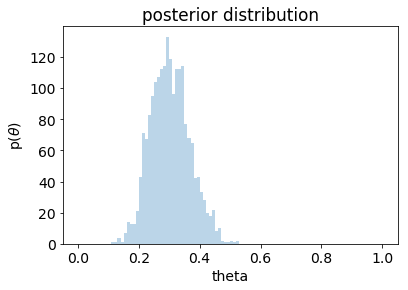

In [16]:
'''posterior distribution'''
print( myresult[:, :, 0].shape )    # select only theta: Ntotal x Nchains
print( myresult[:, :, 0].flatten().shape ) # number of valid chain objects
posterior = myresult[:, :, 0].flatten() # the valid chain objects
histo = plt.hist(posterior, bins=np.linspace(0.0, 1.0, 100+1), alpha=.3)
plt.title('posterior distribution')
plt.xlabel('theta')
plt.ylabel('p($\\theta$)');

In [17]:
'''posterior's Equally Tailed Interval (ETI)'''
theta025 = np.percentile(posterior, 2.5)
theta975 = np.percentile(posterior, 97.5)
print('95% ETI = [{:.3f}, {:.3f}]'.format(theta025, theta975))

95% ETI = [0.188, 0.439]


In [18]:
'''point estimate - Mean Posterior Estimator'''
pomean = posterior.mean()  # Posterior mean
print('posterior mean = {:.3f}'.format(pomean))

'''interval estimate - Posterior's HDI (asymmetrical)'''
import AngStII_Bayes as bayes

hdiinfo = bayes.HDIofGrid(histo[0])
# index of (outer) HDI borders = first and last index
hdi_idx = (hdiinfo['indices'][0], hdiinfo['indices'][-1]+1)
hdi_val = [histo[1][i] for i in hdi_idx] # extract values of bins with index
print('HDI = [{:.3f}, {:.3f}]'.format(hdi_val[0], hdi_val[1]))

posterior mean = 0.303
HDI = [0.190, 0.450]


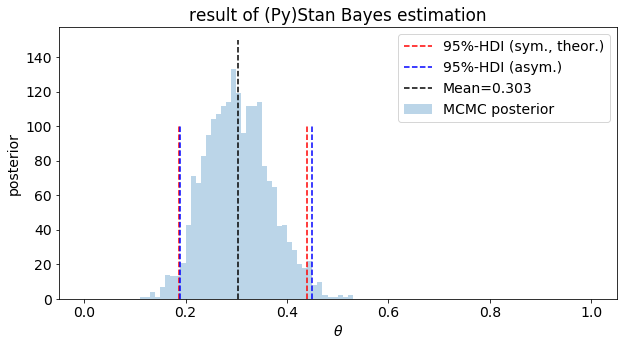

In [19]:
'''histogram with HDI'''
fig = plt.figure(figsize=(10,5))
posterior = myresult[:, :, 0].flatten()
plt.hist(posterior, bins=np.linspace(0.0, 1.0, 100+1),
         alpha=.3, label='MCMC posterior')
plt.plot(2*[theta025], [0., 100], 'r--', label='95%-HDI (sym., theor.)')
plt.plot(2*[theta975], [0., 100], 'r--')        
plt.plot(2*[hdi_val[0]], [0., 100], 'b--', label='95%-HDI (asym.)')
plt.plot(2*[hdi_val[1]], [0., 100], 'b--')    
plt.plot(2*[pomean], [0., 150], 'k--', label='Mean={:.3f}'.format(pomean))
plt.xlabel(r'$\theta$')
plt.ylabel('posterior')
plt.title('result of (Py)Stan Bayes estimation')
plt.legend(loc='upper right');

## Ergebnis PyStan
#### Eingabe
- Modell-String
    - Prior
    - Datenverteilung ($\;\Rightarrow\;$ Likelihood)
    - $\Rightarrow\;$ Posterior
- Daten

#### Ausgabe
- Posterior Markov-Kette(n)
- $\Rightarrow$ Auswertung

## Ausführungs-Varianten

    pystan.stan?
    Signature: pystan.stan(*args, **kwargs)
    Docstring: <no docstring>

In [ ]:
help(pystan.stan)

    Help on function stan in module pystan.api:

    stan(file=None, model_name='anon_model', model_code=None, fit=None, data=None, 
         pars=None, chains=4, iter=2000, warmup=None, thin=1, init='random', 
         seed=None, algorithm=None, control=None, sample_file=None, 
         diagnostic_file=None, verbose=False, boost_lib=None, eigen_lib=None, 
         n_jobs=-1, **kwargs)
    Fit a model using Stan.
    
    Parameters
    ----------
    file : string {'filename', file-like object}
        Model code must found via one of the following parameters: `file` or
        `model_code`.
    model_code : string
        A string containing the Stan model specification. Alternatively,
        the model may be provided with the parameter `file`.
    fit : StanFit instance
        An instance of StanFit derived from a previous fit, None by
        default. If `fit` is not None, the compiled model associated
        with a previous fit is reused and recompilation is avoided.

    data : dict
        A Python dictionary providing the data for the model. Variables
        for Stan are stored in the dictionary as expected. Variable
        names are the keys and the values are their associated values.
        Stan only accepts certain kinds of values; see Notes.
    pars : list of string, optional
        A list of strings indicating parameters of interest. By default
        all parameters specified in the model will be stored.
    chains : int, optional
        Positive integer specifying number of chains. 4 by default.
    iter : int, 2000 by default
        Positive integer specifying how many iterations for each chain
        including warmup.
    warmup : int, iter//2 by default
        Positive integer specifying number of warmup (aka burn-in) iterations.
        As `warmup` also specifies the number of iterations used for stepsize
        adaption, warmup samples should not be used for inference.
    thin : int, optional
        Positive integer specifying the period for saving samples.
        Default is 1.
    n_jobs : int, optional
        Sample in parallel. If -1 all CPUs are used. If 1, no parallel
    [...]    

In [21]:
'''fit once again with different options'''
wup = 3
fit2 = pystan.stan(fit=fit1, data=mydata, iter=100+wup, chains=6, warmup=wup)

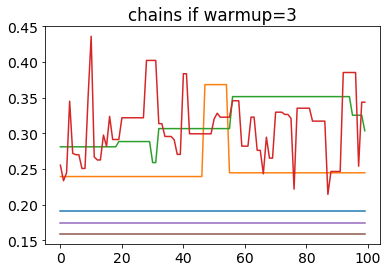

In [22]:
chains = fit2.extract(permuted=False)[:, :, 0]
plt.plot(chains)
plt.title('chains if warmup={}'.format(wup));

In [23]:
'''fit once again with more / enough(?) warmup'''
wup = 100
fit3 = pystan.stan(fit=fit1, data=mydata, iter=100+wup, chains=6, warmup=wup)

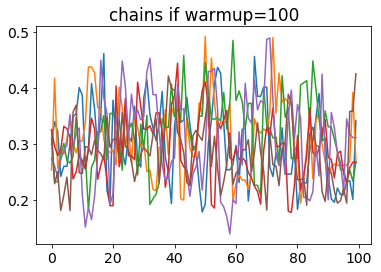

In [24]:
chains = fit3.extract(permuted=False)[:, :, 0]
plt.plot(chains)
plt.title('chains if warmup={}'.format(wup));

# Statistische Auswertung
Übungsstunde

# Beispiel: 2 Münzen
Kommen zwei Münzen aus unterschiedlichen Prägeanstalten?

randomly drawn 18 heads of 50 tosses (36.0)%
randomly drawn 31 heads of 60 tosses (51.7)%
[0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 0 0 0 1 0 0] [0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1
 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0]


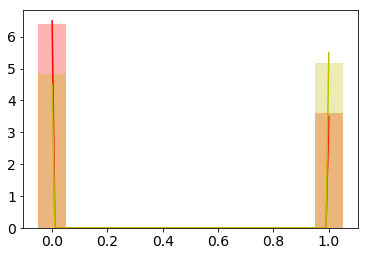

In [25]:
'''two coins - are they the same?
   make the data'''
np.random.seed(987654)
N1 = 50
N2 = 60
t1 = .35               # theta for coin 1, its prior is .50
t2 = .55               # theta for coin 2, same common prior
y1 = stats.bernoulli(t1).rvs(N1)
y2 = stats.bernoulli(t2).rvs(N2)
print('randomly drawn {} heads of {} tosses ({:.1f})%'.format(
                                y1.sum(), len(y1), 100*y1.mean()))
print('randomly drawn {} heads of {} tosses ({:.1f})%'.format(
                                y2.sum(), len(y2), 100*y2.mean()))
bins = np.linspace(-0.05, 1.05, 11+1)
plt.hist(y1, bins=bins, alpha=.3, density=True, color='r')
plt.hist(y2, bins=bins, alpha=.3, density=True, color='y')
x = np.linspace(-0., 1., 100+1)
plt.plot(x, 10*stats.bernoulli(t1).pmf(x), 'r')
plt.plot(x, 10*stats.bernoulli(t2).pmf(x), 'y')
print(y1, y2)

In [26]:
'''the model as a string; will be interpreted by PyStan'''
my2coinsmodel = """
data {
    int<lower=0> N1;                   // number of throws with coin_1
    int<lower=0> N2;                   // number of throws with coin_2
    int y1[N1];                        // data coin_1 0=tails, 1=heads
    int y2[N2];                        // data coin_2 0=tails, 1=heads
}
parameters {
    real<lower=0, upper=1> theta[2];   // parameters for both coins
}
model {
    theta ~ beta( 5, 5 );              // priors for parameters of both coins
    y1 ~ bernoulli( theta[1] );        // vectorized likelihood for data_1
    y2 ~ bernoulli( theta[2] );        // vectorized likelihood for data_2
}
"""

In [27]:
'''data in a dictionary, needed by PyStan; names according to model-string'''
mydata2 = { 
    'N1': len(y1),
    'y1': np.asarray(y1),
    'N2': len(y2),
    'y2': np.asarray(y2)
}

print(mydata2, type(mydata2))

{'N1': 50, 'y1': array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0]), 'N2': 60, 'y2': array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0])} <class 'dict'>


In [28]:
fit2 = pystan.stan(model_code=my2coinsmodel,
                   data=mydata2, iter=1000, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ed99842ddf4b7587f4a2aeabdcd5e0b3 NOW.


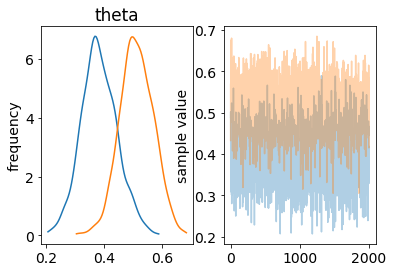

In [29]:
'''show result graphically with built in plot()'''
myplot = fit2.plot()

In [30]:
'''complete result: the chains'''
myresult = fit2.extract(permuted=False)
print(myresult)

[[[  0.50908807   0.59306787 -91.2310105 ]
  [  0.3690181    0.41673694 -89.80739084]
  [  0.43789562   0.6716999  -92.50341683]
  [  0.40853752   0.58628676 -89.24961521]]

 [[  0.47845038   0.64790729 -92.15638716]
  [  0.36965474   0.61763306 -89.99803678]
  [  0.43789562   0.6716999  -92.50341683]
  [  0.40853752   0.58628676 -89.24961521]]

 [[  0.48183546   0.64219239 -92.00667905]
  [  0.43627086   0.52703473 -88.80055801]
  [  0.41208079   0.59920843 -89.56737291]
  [  0.45303604   0.50444903 -89.04107754]]

 ...

 [[  0.3216732    0.61897569 -90.52285175]
  [  0.46659783   0.5961383  -90.2357474 ]
  [  0.34494797   0.46903989 -88.91157495]
  [  0.30023683   0.55584865 -89.61810678]]

 [[  0.34804056   0.60459006 -89.76429487]
  [  0.4213271    0.55258656 -88.8180966 ]
  [  0.37372324   0.5337929  -88.49730688]
  [  0.38081424   0.61860698 -90.00486185]]

 [[  0.44475761   0.42579291 -90.00305769]
  [  0.34290721   0.56702636 -89.03945367]
  [  0.40227649   0.47784496 -88.66312

(500, 4) (500, 4)
(2000,) (2000,)


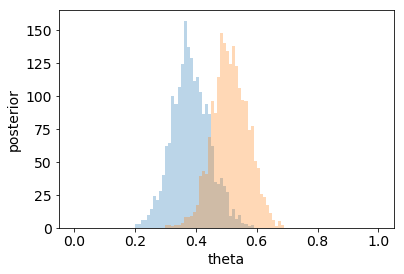

In [31]:
'''resulting Markov chains for both parameters theta'''
# only the both thetas: Ntotal x Nchains
print(myresult[:, :, 0].shape,  myresult[:, :, 1].shape)
posterior1 = myresult[:, :, 0].flatten() # the valid chain objects of coin 1
posterior2 = myresult[:, :, 1].flatten() # the (corresponding) objects of coin 2
print(posterior1.shape, posterior2.shape)# number of total valid chain objects
bins=np.linspace(0.0, 1.0, 100+1)
histo1 = plt.hist(posterior1, bins=bins, alpha=.3)
histo2 = plt.hist(posterior2, bins=bins, alpha=.3)
plt.xlabel('theta')
plt.ylabel('posterior');

- Sind die verschieden?
    - ja klar
    - wirklich, was ist zw. 0.35 und 0.55?
    - **wie in klassischer Statistik?**
        - t-Test (indep?) => dep?
- **!** wir haben den gemeinsamen Posterior, können also di Differenz bilden

difference data has shape (2000,)



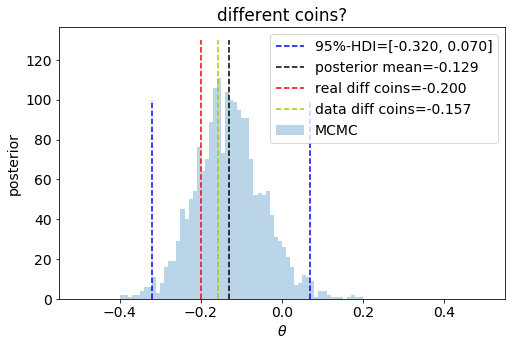

In [32]:
'''is there a difference between coins?'''
fig = plt.figure(figsize=(8, 5))
# valid difference of joint distribution for thetas
postdiff = posterior1 - posterior2
# of the both thetas: Ntotal x Nchains
print('difference data has shape {}'.format(postdiff.shape))
histod = plt.hist(postdiff, bins=np.linspace(-0.5, 0.5, 100+1),
                  alpha=.3, label='MCMC')
pomean = postdiff.mean()
# don't forget to import AngStII_Bayes as bayes
hdiinfo = bayes.HDIofGrid(histod[0])
# index of (outer) HDI borders = 1st and last
hdi_idx = (hdiinfo['indices'][0], hdiinfo['indices'][-1]+1)
hdi_val = [histod[1][i] for i in hdi_idx] # extract values of bins with index
print()
plt.plot(2*[hdi_val[0]], [0., 100], 'b--',
         label='95%-HDI=[{:.3f}, {:.3f}]'.format(hdi_val[0], hdi_val[1])  )
plt.plot(2*[hdi_val[1]], [0., 100], 'b--')    
plt.plot(2*[pomean], [0., 130], 'k--',
         label='posterior mean={:.3f}'.format(pomean))        
plt.plot(2*[t1-t2], [0., 130], 'r--',
         label='real diff coins={:.3f}'.format(t1-t2))
d1, d2 = mydata2['y1'].mean(), mydata2['y2'].mean()
plt.plot(2*[d1-d2], [0., 130], 'y--',
         label='data diff coins={:.3f}'.format(d1-d2))
plt.title('different coins?')
plt.xlabel('$\\theta$')
plt.ylabel('posterior')
plt.legend(loc='upper right');

## Zusatzfrage: unabhängig?

[[3.84455890e-03 7.97068883e-05]
 [7.97068883e-05 3.38171731e-03]] ... posterior's co/variance matrix


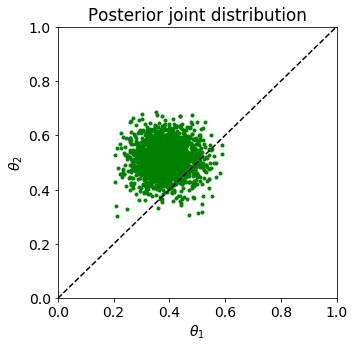

In [34]:
'''Are two coin's posteriors independent?'''
print(np.cov(posterior1, posterior2), "... posterior's co/variance matrix")
plt.figure(figsize=(5, 5))
plt.plot(posterior1, posterior2, 'g.')   # joint scatter distribution
plt.title('Posterior joint distribution')
plt.plot([0, 1], [0, 1], 'k--')          # diagonal: difference==0
plt.axis((0, 1, 0, 1))
plt.xlabel('$\\theta_1$')
plt.ylabel('$\\theta_2$');

## Ergebnis
### Unterscheiden sich zwei Kategorien dichotomer Daten (gemeinsamer Münzwurf)?

- Gemeinsame Verteilung gültiger Posterior-Stichproben
- HDI als 95% Credible Interval für die Differenz 
    - beinhaltet die Nullhypothese $\Delta\theta = 0$
- $\Rightarrow$ Kein Unterschied.
    - Mehr Daten...

# Zusammenfassung
#### Dichotome Daten
- Bernoulliverteilung der Daten

#### Mathematisch geschlossen lösbar
- Beta-Prior
- Bernoulli-Likelihood
- Beta-Posterior

#### Markov Chain Monte Carlo-Methoden
- Ziehen Stichproben direkt aus dem Posterior
    - Posterior = stabile Verteilung
- Metropolis-Algorithmus
- Gibbs-Sampling
- Hamilton Monte Carlo
- No U-Turn Sampler

## Implementierung
- Stan
- PyStan

### Modell-String

    mymodel = """
    data {
        int<lower=0> N;                    // number of coin tosses
        int y1[N];                         // data coin 0=tails, 1=heads
    }
    parameters {
        real<lower=0, upper=1> theta;      // parameters for coin
    }
    model {
        theta ~ beta( 5, 5 );              // prior for parameter of coin
        y1 ~ bernoulli( theta );           // vectorized likelihood for data
    }             """

#### Optional

    transformed parameters {}
    transformed data {}
    generated quantities {}

### Aufruf und Auswertung
    myfit = pystan.stan(model_code=my2model, data=mydata2, iter=1000, chains=4, n_jobs=4)
    print(myfit)
    myfit.plot()
    myfit.extract()

# Literatur
- J. K. Kruschke: "Doing Bayesian Data Analysis, 2nd. A Tutorial with R, JAGS and Stan" Academic Press (2015)

#### Links
- https://github.com/stan-dev/stan
- http://mc-stan.org/users/documentation/
- http://mc-stan.org/users/interfaces/pystan.html
- https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations


# Fragen?